In [1]:
import time
import pickle
import os
import numpy as np
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt
import sys
sys.path.append("../")
import options
import expectations
import iterators
import utils as ut

In [2]:
# numpy seed setup
seed = 29
np.random.seed(seed)

In [3]:
############# run parameters ###############
run_id = 'butterfly_conv_'
S0 = 1.
alpha = .1  # risk aversion parameter
bf_level = 0.1 # higher payoff of the butterfly option
sigma = .20 # volatility of the process (absolute)
m = .05   # drift of the process (absolute)
T = .5 # maturity
step_nr = 100 # steps in the discretization
delta_x = 0.01 # step size of the spatial discretization
drop_optim = False # set to True to save the plots of the optimizers at each step

In [15]:
# Defining the list of models and the factory of the expectations
models = ["Binomial", "Trinomial", "Uniform"]
# expectation factory
class ExpectFactory:

    def __init__(self, model, sigma):
        self.model = model
        self.sigma = sigma
    
    def make_expect(self):
        if self.model == "Binomial": return expectations.binomial_model(sigma=self.sigma)
        elif self.model == "Trinomial": return expectations.trinomial_model(sigma=self.sigma)
        elif self.model == "Uniform": return expectations.uniform_model(sigma=self.sigma)
        elif self.model == "Normal": return expectations.normal_model(sigma=self.sigma)

# defining the risk measure
step_size = T / step_nr
rho_theta = expectations.RhoThetaCertain(alpha=alpha, m=m, t=step_size)

# defining the option
option = options.ButterflyOption(strike=S0, level=bf_level)

Iterating on the models and computing the discrete approximation of the pricing functional.

In [ ]:
for model in models:
    
    model_factory = ExpectFactory(model=model, sigma=sigma)
    model_tmp = model_factory.make_expect()

    print(f"---- Elaboration for {model} model.")
    
    run_id_model = run_id + model_tmp.model

    # defining the spatial grid
    error_propagation = np.absolute(m) * T + model.error_prop() * np.sqrt(T * step_nr)
    print(f"Error propagation from the bounds of the space interval: {error_propagation:.3f}")

    # initializing the space discretization
    x_levels = S0 + np.arange(-.25 - error_propagation, .26 + error_propagation, delta_x)
    print(f"Range of the space discretization: [{np.round(x_levels[0], 3)}, {np.round(x_levels[-1], 3)}]. Discretization step: {np.round(x_levels[1] - x_levels[0], 3)}. Number of points: {x_levels.shape[0]}")

    # initializing the space discretization for the fine interpolation
    x_fine = S0 + np.arange(-.25 - error_propagation, .25 + error_propagation, 0.001)
    print(f"Range of the fine space discretization: [{np.round(x_fine[0], 3)}, {np.round(x_fine[-1], 3)}]. Discretization step: {np.round(x_fine[1] - x_fine[0], 3)}. Number of points: {x_fine.shape[0]}")

    # plot coordinates
    x_plot = S0 + np.arange(-.25, .26, 0.01)

    # performing the iteration
    iter_dict, theta_dict, expect_dict = iterators.certain_iterations(x_levels=x_levels, x_fine=x_fine, option=option, step_nr=step_nr, rho_theta=rho_theta, make_expect=model_factory.make_expect)

    # setting latex style for plots
    plt.rcParams['text.usetex'] = True
    plt.rcParams['font.size'] = 13
    plt.rcParams['legend.fontsize'] = 13
    
    # dropping the optimizers at each step
    if drop_optim:
        # checking (or creating) the output folder
        plots_dir = os.path.join(os.path.pardir,'output', run_id_model, 'optimizers')
        ut.check_dir(plots_dir)

        # plotting the hedging strategy at each step of the iteration
        for i in range(1, step_nr + 1):

            hedging = np.interp(x_plot, x_levels, theta_dict[i])
            plt.plot(x_plot, hedging, color='tab:blue')
            plt.xlabel('$S$')
            plt.ylabel(r'$\theta^*$')
            plt.tight_layout()
            plt.savefig(os.path.join(plots_dir, f'iteration_{i:3d}.png'), bbox_inches='tight')
            plt.close()

    # saving the trading strategy and the iterations for later use
    dict_dir = os.path.join(os.path.pardir,'output', run_id_model)
    out_dict = {
        "option": option,
        "maturity": T,
        "step_nr": step_nr,
        "training_model": model_tmp.model,
        "delta_x": delta_x,
        "x_theta": x_levels,
        "theta_trained": theta_dict,
        "x_I": x_fine,
        "I_trained": iter_dict
    }

    # checking (or creating) the output folder
    ut.check_dir(dict_dir)

    # Save the dictionary to a pickle binary file
    with open(os.path.join(dict_dir,'trained_model.pkl'), 'wb') as pickle_file:
        pickle.dump(out_dict, pickle_file)

Loading the models. Once the models are created, the previous cell can be omitted in following elaborations and we can directly work on the output of the first elaboration.

In [16]:
# loading the trained models
line_styles = ['--', '-.', ':', (5, (10, 3)), (0,(3,5,1,5,1,5)), (0, (1, 1))]
models_dict = {}
for mod in models:
    model_label = "butterfly_conv_" + mod
    model_dict_dir = os.path.join(os.path.pardir, "output", model_label)
    with open(os.path.join(model_dict_dir, "trained_model.pkl"), 'rb') as pickle_file:
        models_dict[mod] = pickle.load(pickle_file)

Plotting the resulting approximated $S(T)f$ with respect to the different models.

In [17]:
# setting latex style for plots
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 13
plt.rcParams['legend.fontsize'] = 13

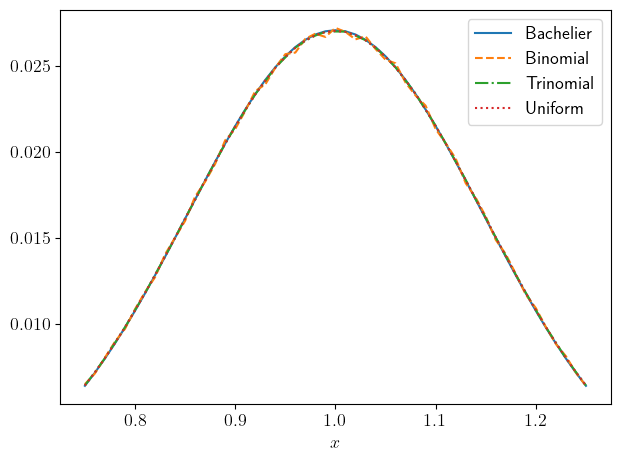

Binomial model mean square error: 2.1274e-08
Trinomial model mean square error: 1.1589e-09
Uniform model mean square error: 6.4611e-10


In [18]:
# plot coordinates
x_plot = S0 * (1 + np.arange(-.25, .26, 0.01))

# plotting Bachelier prices
bachelier_levels = option.bachelier_price(x_plot, T, sigma)
plt.plot(x_plot, bachelier_levels, label="Bachelier")

# plotting simulated prices with different levels
for j, mod in enumerate(models):
    
    models_dict[mod]['model_levels'] = np.interp(x_plot, models_dict[mod]['x_I'], models_dict[mod]['I_trained'][models_dict[mod]['step_nr']])
    plt.plot(x_plot, models_dict[mod]['model_levels'], linestyle=line_styles[j], label=mod)
    plt.xlabel(f"$x$")
plt.legend()
plt.tight_layout()
plt.show()

# printing the L2 error for the different models
for mod in models:
    print(f"{mod} model mean square error: {np.mean(np.power(models_dict[mod]['model_levels'] - bachelier_levels, 2)):.4e}")

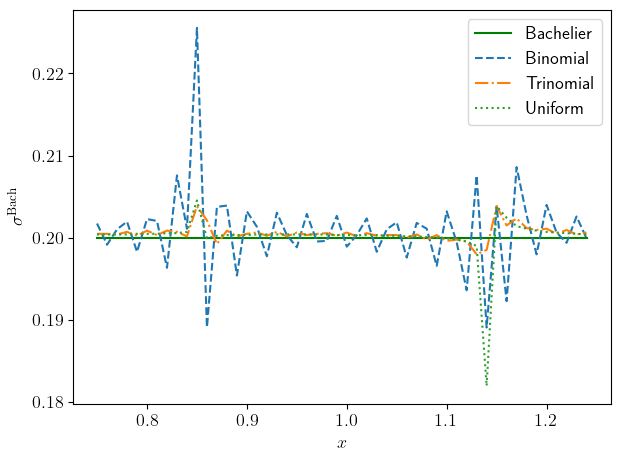

In [19]:
# defining the range of the plot for the implied volatility
x_vol_mask = (x_plot >= (0.75 * S0)) * (x_plot <= (1.25 * S0))
x_vol_levels = x_plot[x_vol_mask]

# computing and plotting the implied volatilities with respect to the Bachelier model
bachelier_vols = [option.bach_implied_vol(bachelier_levels[x_vol_mask][i], x_vol_levels[i], T) for i in range(len(x_vol_levels))]
plt.plot(x_vol_levels, bachelier_vols, color='green', label='Bachelier')

# plotting the implied volatilites from the different models
for j, mod in enumerate(models):
    impl_vol_list = [option.bach_implied_vol(models_dict[mod]['model_levels'][x_vol_mask][i], x_vol_levels[i], T) for i in range(len(x_vol_levels))]
    plt.plot(x_vol_levels, impl_vol_list, linestyle=line_styles[j], label=mod)
    plt.xlabel('$x$')

plt.ylabel(r"$\sigma^{\rm Bach}$")
plt.legend()
plt.tight_layout()
plt.show()

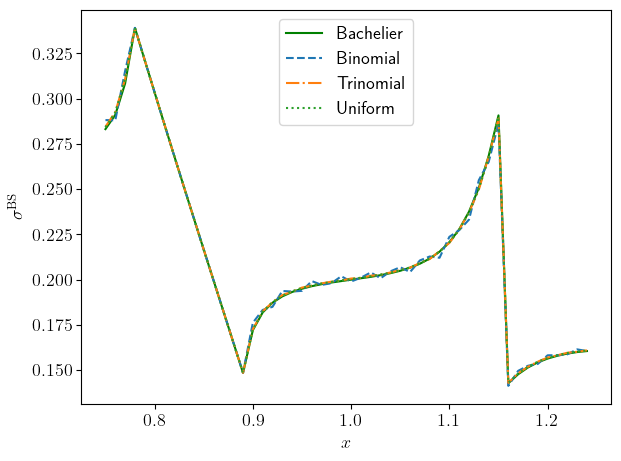

In [20]:
# computing and plotting the implied volatilities with respect to the Blach-Scholes model
bachelier_vols = [option.bs_implied_vol(bachelier_levels[x_vol_mask][i], x_vol_levels[i], T) for i in range(len(x_vol_levels))]
plt.plot(x_vol_levels, bachelier_vols, color='green', label='Bachelier')

# plotting the implied volatilites from the different models
for j, mod in enumerate(models):
    impl_vol_list = [option.bs_implied_vol(models_dict[mod]['model_levels'][x_vol_mask][i], x_vol_levels[i], T) for i in range(len(x_vol_levels))]
    plt.plot(x_vol_levels, impl_vol_list, linestyle=line_styles[j], label=mod)
    plt.xlabel('$x$')

plt.ylabel(r"$\sigma^{\rm BS}$")
plt.legend()
plt.tight_layout()
plt.show()